### Plant Leaf Disease Detection and Classification Based on CNN with LVQ Algorithm

<div style="text-align: right;">
  <h5 style="margin-bottom: 2px;">Abhishek Kumar [21EE01051]</h5>
  <h5 style="margin-top: 2px;">Priyanshu Mathur [21EC01044]</h5>
</div>


In [ ]:
# Before running this file, make sure to install dependencies in the bash:
# pip install tensorflow keras numpy opencv-python matplotlib scikit-learn

In [12]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Set dataset path
dataset_path = "dataset"
img_size = (128, 128)

# Load images and labels
X, y = [], []
labels = sorted(os.listdir(dataset_path))  # Get folder names

for label in labels:
    label_path = os.path.join(dataset_path, label)
    for img_name in os.listdir(label_path):
        img_path = os.path.join(label_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        X.append(img)
        y.append(label)

# Convert to numpy arrays
X = np.array(X, dtype="float32") / 255.0  # Normalize
y = np.array(y)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [3]:
# CNN Model
cnn_model = Sequential([
    Conv2D(32, (9,9), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (9,9), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (5,5), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (5,5), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(labels), activation='softmax')  # Output layer
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 32)      7808      
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 52, 52, 64)        165952    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 26, 26, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 128)       204928    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 11, 11, 128)     

In [4]:
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10


319/319 [==============================] - 152s 471ms/step - loss: 1.0218 - accuracy: 0.5838 - val_loss: 0.6415 - val_accuracy: 0.7605
Epoch 2/10
319/319 [==============================] - 158s 496ms/step - loss: 0.6635 - accuracy: 0.7499 - val_loss: 0.5082 - val_accuracy: 0.8118
Epoch 3/10
319/319 [==============================] - 176s 551ms/step - loss: 0.4927 - accuracy: 0.8171 - val_loss: 0.3953 - val_accuracy: 0.8538
Epoch 4/10
319/319 [==============================] - 152s 475ms/step - loss: 0.3802 - accuracy: 0.8613 - val_loss: 0.2803 - val_accuracy: 0.8981
Epoch 5/10
319/319 [==============================] - 159s 499ms/step - loss: 0.3047 - accuracy: 0.8897 - val_loss: 0.2789 - val_accuracy: 0.9020
Epoch 6/10
319/319 [==============================] - 192s 601ms/step - loss: 0.2678 - accuracy: 0.9056 - val_loss: 0.2738 - val_accuracy: 0.9044
Epoch 7/10
319/319 [==============================] - 183s 575ms/step - loss: 0.2137 - accuracy: 0.9232 - val_loss: 0.1793

In [5]:
feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-3].output)

X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

80/80 [==============================] - 12s 154ms/step


In [6]:
lvq_model = MLPClassifier(hidden_layer_sizes=(128,), max_iter=500, activation='relu', solver='adam')
lvq_model.fit(X_train_features, y_train)

# Evaluate on test set
accuracy = lvq_model.score(X_test_features, y_test)
print(f"LVQ Test Accuracy: {accuracy * 100:.2f}%")

LVQ Test Accuracy: 95.49%


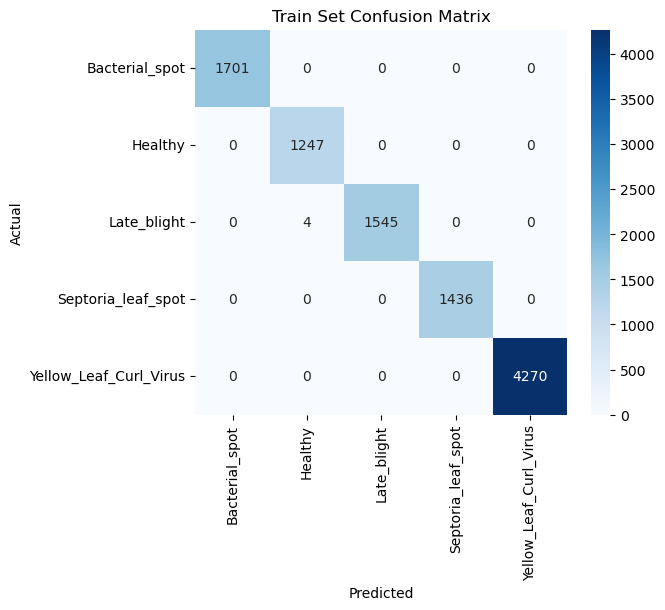

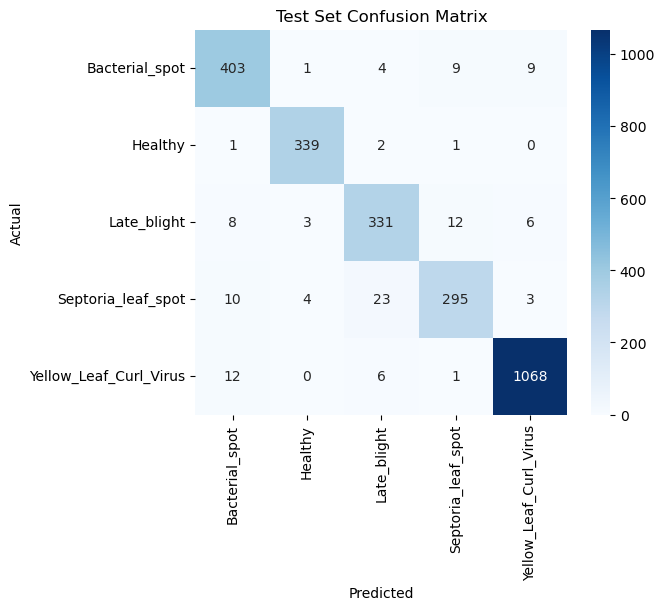

In [14]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# Predictions on train and test datasets
y_train_pred = lvq_model.predict(X_train_features)
y_test_pred = lvq_model.predict(X_test_features)

# Plot confusion matrices
plot_confusion_matrix(y_train, y_train_pred, "Train Set Confusion Matrix")
plot_confusion_matrix(y_test, y_test_pred, "Test Set Confusion Matrix")

In [10]:
def predict_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)
    img = np.expand_dims(img, axis=0) / 255.0  # Normalize

    # Extract CNN features
    features = feature_extractor.predict(img)
    
    # Predict using LVQ
    prediction = lvq_model.predict(features)
    class_name = label_encoder.inverse_transform(prediction)[0]

    return class_name

In [11]:
# Test an image
test_img = "test_leaf_2.jpg" 
print("Predicted class:", predict_image(test_img))

1/1 [==============================] - 0s 28ms/step
Predicted class: Septoria_leaf_spot
